## Previsão de Vendas Semanais (2012) — RF vs XGBoost (Forecast Iterativo)

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# XGBoost 
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    print("XGBoost não disponível. Instale com: pip install xgboost")
    XGB_AVAILABLE = False

# Regras dos gráficos: matplotlib, 1 gráfico por figura, sem cores específicas
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = False

In [ ]:
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / np.clip(y_true, eps, None))) * 100

def iterative_forecast(model, X_test, lag_col='Weekly_Sales_lag_1'):
    Xt = X_test.copy() 
    preds = []
    for i in range(len(Xt)):
        p = model.predict(Xt.iloc[[i]])[0]
        preds.append(p)
        if i + 1 < len(Xt):
            Xt.iloc[i+1, Xt.columns.get_loc(lag_col)] = p
    return np.array(preds)

def plot_series(dates, y, yhat, title):
    plt.figure(); plt.plot(dates, y, label="Real"); plt.plot(dates, yhat, label="Previsto")
    plt.title(title); plt.xlabel("Data"); plt.ylabel("Vendas Semanais"); plt.legend(); plt.tight_layout(); plt.show()

def plot_scatter(y, yhat, title):
    plt.figure(); plt.scatter(y, yhat, s=10)
    mn = min(np.min(y), np.min(yhat)); mx = max(np.max(y), np.max(yhat))
    plt.plot([mn, mx], [mn, mx])
    plt.title(title); plt.xlabel("Real"); plt.ylabel("Previsto"); plt.tight_layout(); plt.show()

def plot_corr_heatmap(df, title="Correlação (Pearson)"):
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(8,6)); im = plt.imshow(corr, aspect='auto')
    plt.title(title)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def plot_error_over_time(dates, y, yhat, title="Erro ao longo do tempo"):
    e = np.array(y) - np.array(yhat)
    plt.figure(); plt.plot(dates, e)
    plt.title(title); plt.xlabel("Data"); plt.ylabel("Erro (real - previsto)")
    plt.tight_layout(); plt.show()

def plot_error_box_by_month(dates, y, yhat, title="Erro por mês"):
    dfm = pd.DataFrame({"date": pd.to_datetime(dates), "err": np.array(y) - np.array(yhat)})
    dfm["month"] = dfm["date"].dt.month
    data = [dfm[dfm["month"]==m]["err"].values for m in sorted(dfm["month"].unique())]
    plt.figure(); plt.boxplot(data, labels=sorted(dfm["month"].unique()))
    plt.title(title); plt.xlabel("Mês"); plt.ylabel("Erro")
    plt.tight_layout(); plt.show()

## 1) Carregar e preparar dados


In [4]:
DATA_PATH = Path("sales.csv")  # ajuste o caminho se necessário
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df = df.sort_values("Date").reset_index(drop=True)

# Ajuste de escala (conforme enunciado)
if (df["Fuel_Price"] > 100).any(): df["Fuel_Price"] = df["Fuel_Price"]/1000.0
if (df["Unemployment"] > 100).any(): df["Unemployment"] = df["Unemployment"]/1000.0

# Features temporais
df["month"] = df["Date"].dt.month
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# Lag para forecast iterativo
df["Weekly_Sales_lag_1"] = df["Weekly_Sales"].shift(1)

# Drop das primeiras linhas com NaN por causa do lag
df = df.dropna().reset_index(drop=True)

print(df.head())
print("Período:", df["Date"].min(), "->", df["Date"].max())

        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0 2010-02-12    1641957.44             1        38.51       2.548  211.242170   
1 2010-02-19    1611968.17             0        39.93       2.514  211.289143   
2 2010-02-26    1409727.59             0        46.63       2.561  211.319643   
3 2010-03-05    1554806.68             0        46.50       2.625  211.350143   
4 2010-03-12    1439541.59             0        57.79       2.667  211.380643   

   Unemployment  month  month_sin     month_cos  Weekly_Sales_lag_1  
0         8.106      2   0.866025  5.000000e-01          1643690.90  
1         8.106      2   0.866025  5.000000e-01          1641957.44  
2         8.106      2   0.866025  5.000000e-01          1611968.17  
3         8.106      3   1.000000  6.123234e-17          1409727.59  
4         8.106      3   1.000000  6.123234e-17          1554806.68  
Período: 2010-02-12 00:00:00 -> 2012-10-26 00:00:00



## 2) Split temporal (treina < 2012, testa >= 2012)

In [5]:
cutoff = pd.Timestamp("2012-01-01")
train_df = df[df["Date"] < cutoff].copy()
test_df  = df[df["Date"] >= cutoff].copy()

target = "Weekly_Sales"
features = [
    "Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment",
    "month_sin","month_cos","Weekly_Sales_lag_1"
]

X_train = train_df[features].copy(); y_train = train_df[target].copy()
X_test  = test_df[features].copy();  y_test  = test_df[target].copy()

print("Shape treino:", X_train.shape, "| teste:", X_test.shape)

Shape treino: (99, 8) | teste: (43, 8)


## 3) Heatmap de correlação

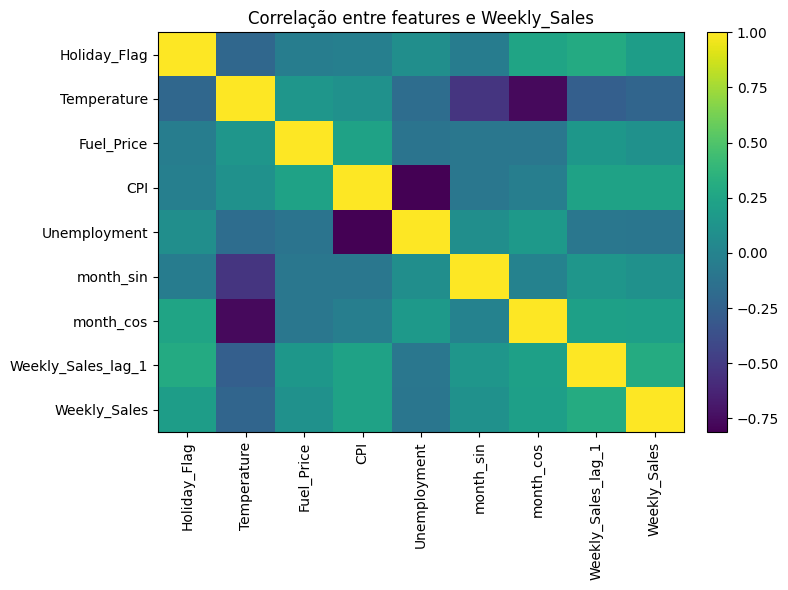

In [6]:
plot_corr_heatmap(df[features + [target]], title="Correlação entre features e Weekly_Sales")

## 4) Treinamento — RandomForest e XGBoost + Forecast Iterativo

In [7]:
# Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = iterative_forecast(rf, X_test, lag_col="Weekly_Sales_lag_1")

# XGBoost (se disponível)
pred_xgb = None
if XGB_AVAILABLE:
    xgb = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
    )
    xgb.fit(X_train, y_train)
    pred_xgb = iterative_forecast(xgb, X_test, lag_col="Weekly_Sales_lag_1")
else:
    print("XGBoost indisponível — instale xgboost para comparar.")

## 5) Métricas (RMSE, R², MAPE)

In [9]:
res = [{
    "Modelo": "RandomForest",
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_rf)),
    "R2": r2_score(y_test, pred_rf),
    "MAPE": mape(y_test, pred_rf)
}]

if pred_xgb is not None:
    res.append({
        "Modelo": "XGBoost",
        "RMSE": np.sqrt(mean_squared_error(y_test, pred_xgb)),
        "R2": r2_score(y_test, pred_xgb),
        "MAPE": mape(y_test, pred_xgb)
    })

pd.DataFrame(res)


,Modelo,RMSE,R2,MAPE
0,RandomForest,264482.286282,-4.407498,15.840586
1,XGBoost,122790.352793,-0.165552,6.109629


 ## 6) Gráficos — Série Temporal e Dispersão

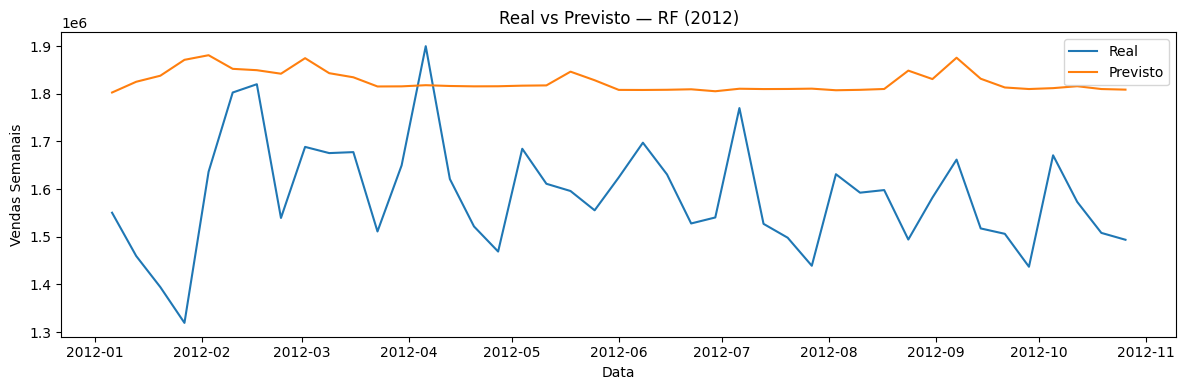

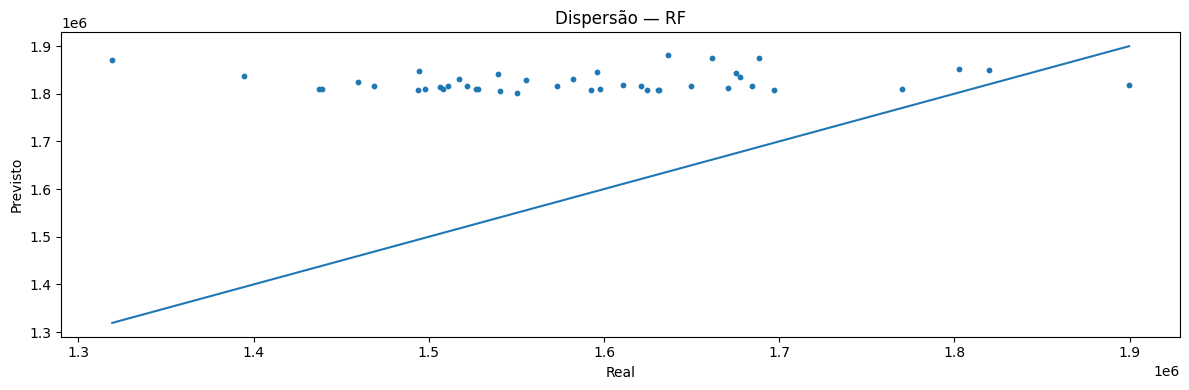

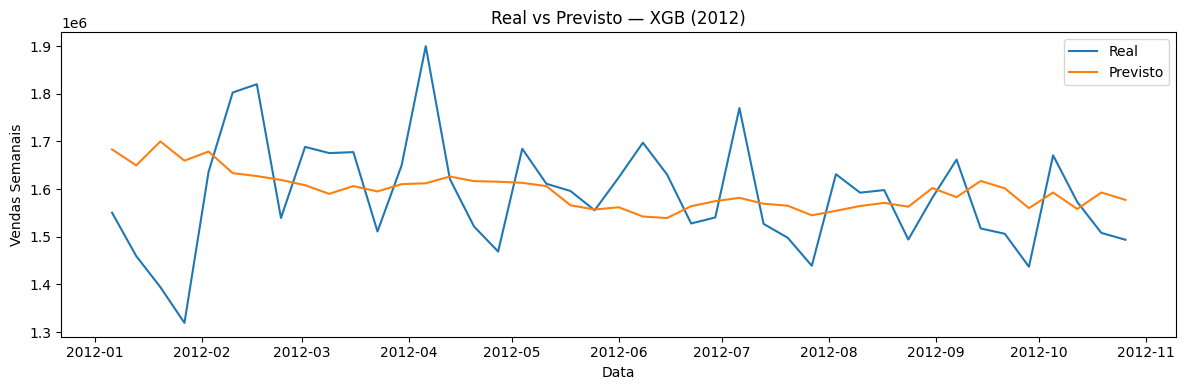

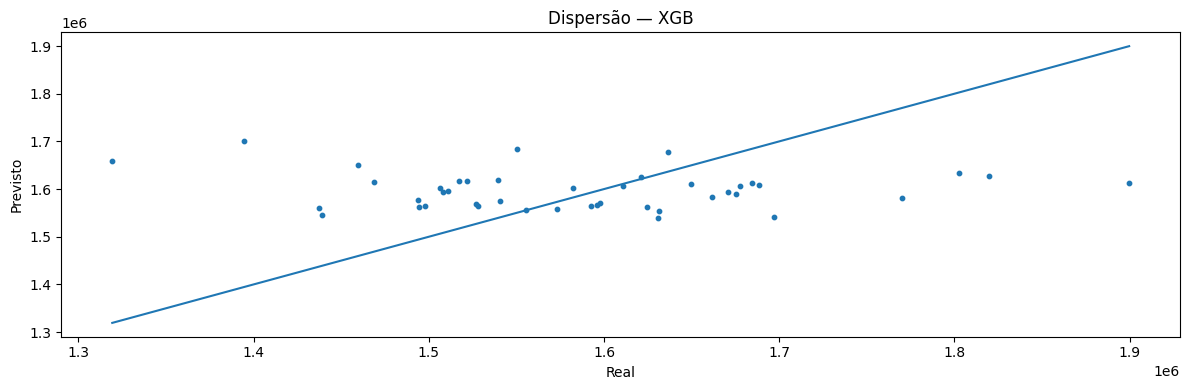

In [10]:
plot_series(test_df["Date"], y_test.values, pred_rf, "Real vs Previsto — RF (2012)")
plot_scatter(y_test.values, pred_rf, "Dispersão — RF")
if pred_xgb is not None:
    plot_series(test_df["Date"], y_test.values, pred_xgb, "Real vs Previsto — XGB (2012)")
    plot_scatter(y_test.values, pred_xgb, "Dispersão — XGB")


## 7) Erro ao longo do tempo e Boxplot por mês

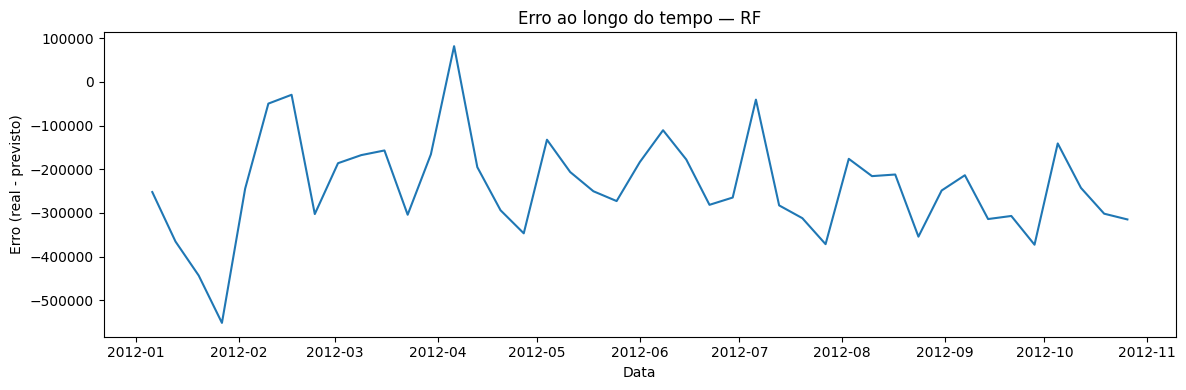

C:\Users\helde\AppData\Local\Temp\ipykernel_18484\2018491613.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(data, labels=sorted(dfm["month"].unique()))


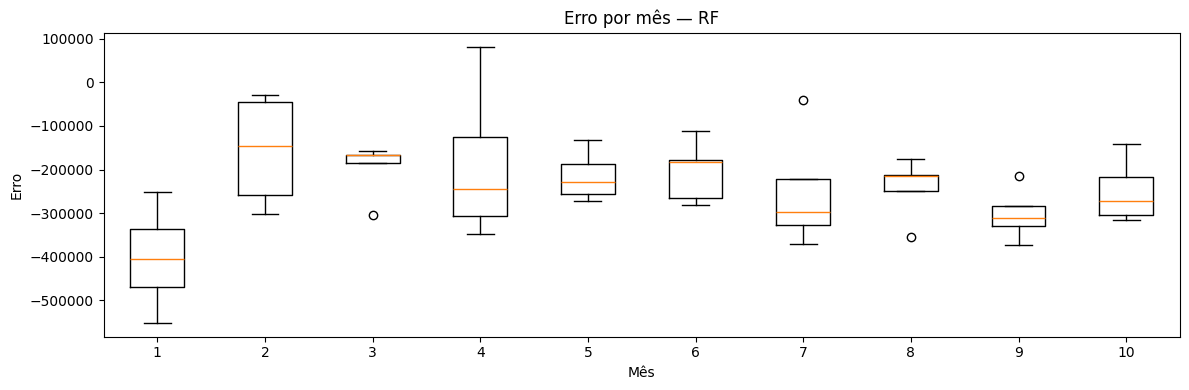

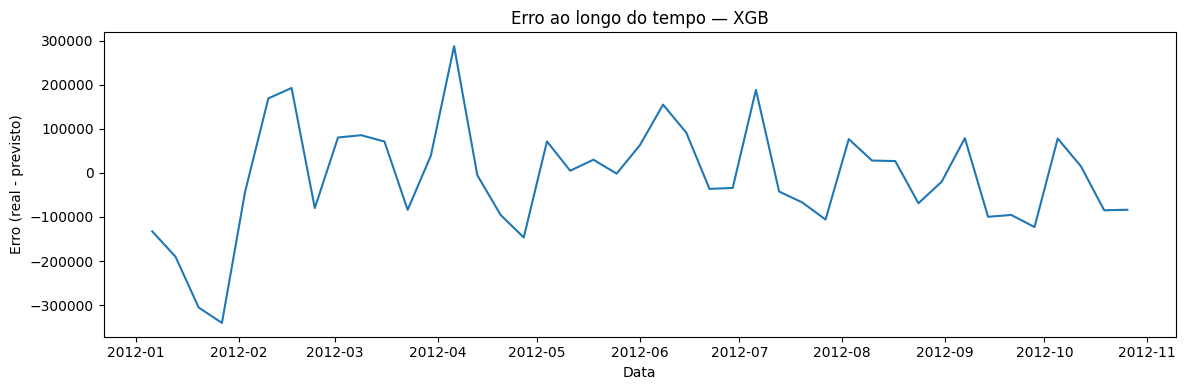

C:\Users\helde\AppData\Local\Temp\ipykernel_18484\2018491613.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(); plt.boxplot(data, labels=sorted(dfm["month"].unique()))


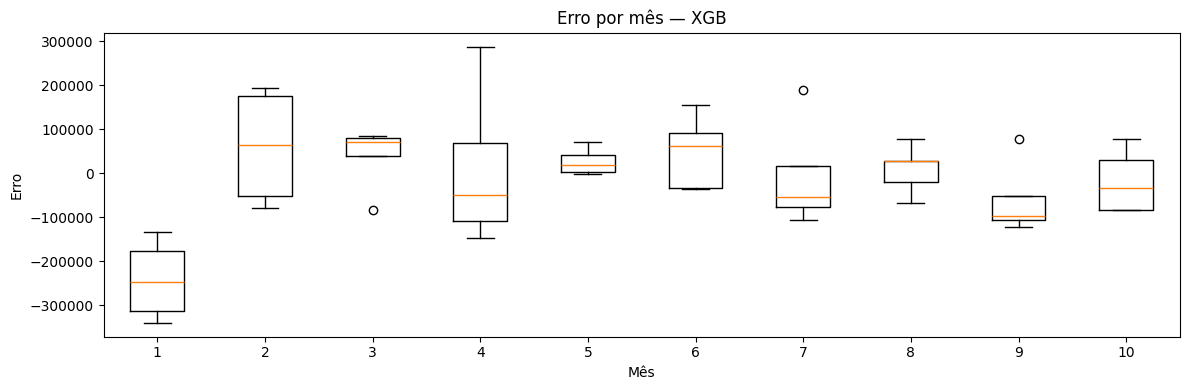

In [11]:
plot_error_over_time(test_df["Date"], y_test.values, pred_rf, "Erro ao longo do tempo — RF")
plot_error_box_by_month(test_df["Date"], y_test.values, pred_rf, "Erro por mês — RF")
if pred_xgb is not None:
    plot_error_over_time(test_df["Date"], y_test.values, pred_xgb, "Erro ao longo do tempo — XGB")
    plot_error_box_by_month(test_df["Date"], y_test.values, pred_xgb, "Erro por mês — XGB")

## 8) Importância de Features (RF e XGB)

In [12]:
imp_rf = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
imp_rf

,feature,importance
3,CPI,0.247388
7,Weekly_Sales_lag_1,0.234426
6,month_cos,0.194615
1,Temperature,0.138209
2,Fuel_Price,0.100341
0,Holiday_Flag,0.051612
4,Unemployment,0.017116
5,month_sin,0.016292


In [14]:
if XGB_AVAILABLE:
    try:
        imp_xgb = pd.DataFrame({"feature": features, "importance": xgb.feature_importances_}).sort_values("importance", ascending=False)
        display(imp_xgb)
    
    except Exception as e:
        print("Falha ao extrair importância do XGB:", e)

,feature,importance
6,month_cos,0.600516
0,Holiday_Flag,0.170650
7,Weekly_Sales_lag_1,0.093886
3,CPI,0.040731
4,Unemployment,0.037063
2,Fuel_Price,0.021311
1,Temperature,0.019678
5,month_sin,0.016164


## 9) Conclusões e Recomendações

- Forecast **iterativo** (sem vazamento) reflete uso real em produção.
- **Sazonalidade** (senos/cossenos) e **lag** ajudam a capturar padrões de negócio.
- Compare RF vs XGB por **RMSE/R²/MAPE**, monitore mensalmente.
- Próximos passos: incluir `lag_4` e `lag_52` (previsão encadeada), médias móveis 4/12 semanas calculadas só com histórico conhecido, `TimeSeriesSplit` e, se quiser, LightGBM.
